# Fine-Tuned BERT for IMDb Review Sentiment Analysis
ADSP 31009 IP03 Machine Learning & Predictive Analytics – Final Project  
Daichi Ishikawa

## Agenda
- 0. Environment Setup
- 1. Data Preprocessing and EDA
- 2. Naive Bayes (Baseline Model)
- 3. Fine-Tuning BERT
    - 3-0. Data Preprocessing for Fine-Tuning BERT
    - 3-1. Fine-tuning BERT - Dense Layer Only
        - 3-1-1. Learning Rate = 5e-5, Epoch = 4
        - 3-1-2. Learning Rate = 1e-3, Epoch = 10
    - 3-2. Fine-tuning BERT - Dense Layer and 1 Encoder Layer
        - 3-2-1. Learning Rate = 1e-3, Epoch = 10
        - 3-2-2. Learning Rate = 1e-4, Epoch = 10
    - 3-3. Fine-tuning BERT - Dense Layer and 3 Encoder Layers
        - 3-3-1. Learning Rate = 1e-4, Epoch = 10
        - 3-3-2. Learning Rate = 1e-5, Epoch = 10

## 0. Environment Setup

In [2]:
# Ensure compatibility between TensorFlow and Keras versions
# Upgrade tf_keras to ensure compatibility with TensorFlow
!pip install -U tf_keras

import os
# Use legacy Keras for compatibility with older Keras-based code
os.environ["TF_USE_LEGACY_KERAS"] = "1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [3]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

from transformers import BertTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Data Preprocessing and EDA

In [ ]:
# Load dataset
df = pd.read_csv('movie.csv')
df = df.sample(n=10000, random_state=42)

# check data
df.head()

,text,label
32823,"The central theme in this movie seems to be confusion, as the relationships, setting, acting and social context all lead to the same place: confusion. Even Harvey Keitel appears to be out of his element, and lacks his usual impeccable clarity, direction and intensity. To make matters worse, his character's name is 'Che', and we are only told (directly, by the narrator) well into the film that he is not 'that' Che, just a guy named Che. The family relationships remain unclear until the end of the film, and once defined, the family is divided - the younger generation off to America. So cliché. Other reviews discuss how the movie depicts the impact of the revolution on a boy's family; however the political stance of the director is murky at best, and we are never quite sure who is responsible for what bloodshed. So they lost their property (acquired by gambling profits) - so what? Refusing to take a political stand, when making a movie about the Cuban revolution, is an odd and cowardly choice. Not to mention the movie was in English! Why are all these Cubans speaking English? No wonder they did not get permission to film in Cuba. And if family life is most important to look at here, it would be great if we could figure out who is who - we are 'introduced' to them all in the beginning - a cheap way out of making the relationships clear throughout the film! The acting was mostly shallow, wooden, and unbelievable, timing was off all around. The 'special' visual effects were confusing and distracting. References to American films - and the black character as Greek chorus - strictly gratuitous, intellectually ostentatious, and consistently out of place. I only watched the whole movie because I was waiting for clarity, or some point to it all. It never happened.",0
16298,"An excellent example of ""cowboy noir"", as it's been called, in which unemployed Michael (Nicolas Cage) loses out on a job because he insists on being honest (he's got a bum leg). With really nothing else he can do, he decides that for once he's going to lie. When he walks into a bar, and the owner Wayne (the late, great J.T. Walsh) mistakes him for a hit-man whom Wayne has hired to do in his sexy young wife Suzanne (Lara Flynn Boyle in fine form), Michael plays along and accepts Waynes' money. *Then* he goes to Suzanne and informs her of her husbands' intentions, and accepts *her* money to get rid of Wayne! If that didn't complicate things enough, the real hit-man, ""Lyle from Dallas"" (Dennis Hopper, in a perfect role for him) shows up and Michael is in even more trouble than before.<br /><br />""Red Rock West"" gets a lot out of the locations. Director John Dahl, who co-wrote the script with his brother Rick, was smart in realizing the potential of a story set in a truly isolated small town that may have seen better days and in which the residents could be involved in any manner of schemes. It's also an amusing idea of the kind of trouble an honest person could get into if they decided to abandon their principles and give in to any level of temptation. It's an appreciably dark and twist-laden story with an assortment of main characters that are if not corrupt, have at least been morally compromised like Michael. The lighting by cinematographer Marc Reshovsky is superb in its moodiness; even the climax set in a graveyard lends a nice morbid quality to the whole thing. Even if the writing isn't particularly ""logical or credible"", the film has a nice way of intriguing the viewer and just drawing them right in.<br /><br />Cage does a good job in the lead, but his co-stars have a grand old time sinking their teeth into their meaty and greed-motivated characters. Hopper, Boyle, and Walsh are all fun to watch in these parts. Timothy Carhart and Dan Shor are fine as Walshs' deputies (in one especially good twist, Walsh is also the local sheriff), and there's an entertaining cameo role for country & western star Dwight Yoakam, who also graces the film 

In [ ]:
# Check shape
df.shape

(10000, 2)

In [ ]:
# Check missing value
pd.isna(df).sum()

text     0
label    0
dtype: int64

In [ ]:
#　Remove duplication
df.drop_duplicates(subset='text', inplace=True)
df.shape

(9978, 2)

In [ ]:
# Count label
# Sentiment: 0 - negative　, 1 - positive
df['label'].value_counts()

label
1    5038
0    4940
Name: count, dtype: int64

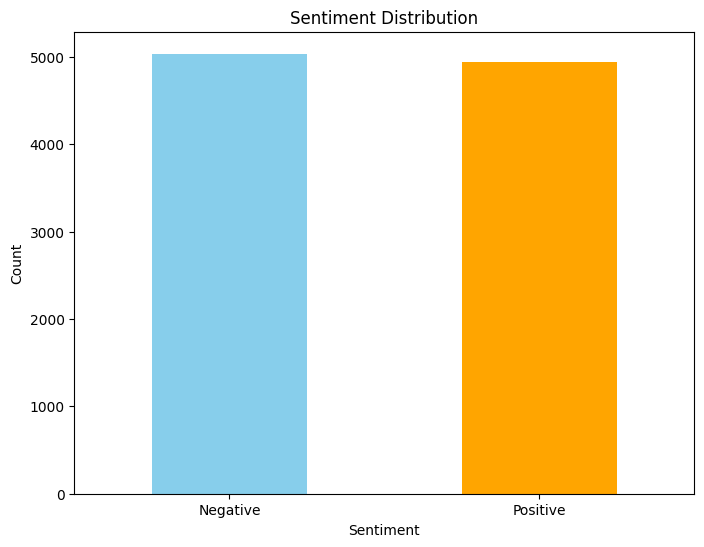

In [ ]:
# Plot label count
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

In [ ]:
# Remove HTML tags
df['text'] = df['text'].apply(lambda x: re.sub(r'<[^>]+>', '', x))

In [ ]:
df.head()

,text,label
32823,"The central theme in this movie seems to be confusion, as the relationships, setting, acting and social context all lead to the same place: confusion. Even Harvey Keitel appears to be out of his element, and lacks his usual impeccable clarity, direction and intensity. To make matters worse, his character's name is 'Che', and we are only told (directly, by the narrator) well into the film that he is not 'that' Che, just a guy named Che. The family relationships remain unclear until the end of the film, and once defined, the family is divided - the younger generation off to America. So cliché. Other reviews discuss how the movie depicts the impact of the revolution on a boy's family; however the political stance of the director is murky at best, and we are never quite sure who is responsible for what bloodshed. So they lost their property (acquired by gambling profits) - so what? Refusing to take a political stand, when making a movie about the Cuban revolution, is an odd and cowardly choice. Not to mention the movie was in English! Why are all these Cubans speaking English? No wonder they did not get permission to film in Cuba. And if family life is most important to look at here, it would be great if we could figure out who is who - we are 'introduced' to them all in the beginning - a cheap way out of making the relationships clear throughout the film! The acting was mostly shallow, wooden, and unbelievable, timing was off all around. The 'special' visual effects were confusing and distracting. References to American films - and the black character as Greek chorus - strictly gratuitous, intellectually ostentatious, and consistently out of place. I only watched the whole movie because I was waiting for clarity, or some point to it all. It never happened.",0
16298,"An excellent example of ""cowboy noir"", as it's been called, in which unemployed Michael (Nicolas Cage) loses out on a job because he insists on being honest (he's got a bum leg). With really nothing else he can do, he decides that for once he's going to lie. When he walks into a bar, and the owner Wayne (the late, great J.T. Walsh) mistakes him for a hit-man whom Wayne has hired to do in his sexy young wife Suzanne (Lara Flynn Boyle in fine form), Michael plays along and accepts Waynes' money. *Then* he goes to Suzanne and informs her of her husbands' intentions, and accepts *her* money to get rid of Wayne! If that didn't complicate things enough, the real hit-man, ""Lyle from Dallas"" (Dennis Hopper, in a perfect role for him) shows up and Michael is in even more trouble than before.""Red Rock West"" gets a lot out of the locations. Director John Dahl, who co-wrote the script with his brother Rick, was smart in realizing the potential of a story set in a truly isolated small town that may have seen better days and in which the residents could be involved in any manner of schemes. It's also an amusing idea of the kind of trouble an honest person could get into if they decided to abandon their principles and give in to any level of temptation. It's an appreciably dark and twist-laden story with an assortment of main characters that are if not corrupt, have at least been morally compromised like Michael. The lighting by cinematographer Marc Reshovsky is superb in its moodiness; even the climax set in a graveyard lends a nice morbid quality to the whole thing. Even if the writing isn't particularly ""logical or credible"", the film has a nice way of intriguing the viewer and just drawing them right in.Cage does a good job in the lead, but his co-stars have a grand old time sinking their teeth into their meaty and greed-motivated characters. Hopper, Boyle, and Walsh are all fun to watch in these parts. Timothy Carhart and Dan Shor are fine as Walshs' deputies (in one especially good twist, Walsh is also the local sheriff), and there's an entertaining cameo role for country & western star Dwight Yoakam, who also graces the film with an enjoyable end cr

In [ ]:
# Token count
df['token_count'] = df['text'].apply(lambda x: len(x.split()))
df['token_count'].describe()

count    9978.000000
mean      230.521948
std       170.411312
min         4.000000
25%       125.000000
50%       174.000000
75%       282.000000
max      2192.000000
Name: token_count, dtype: float64

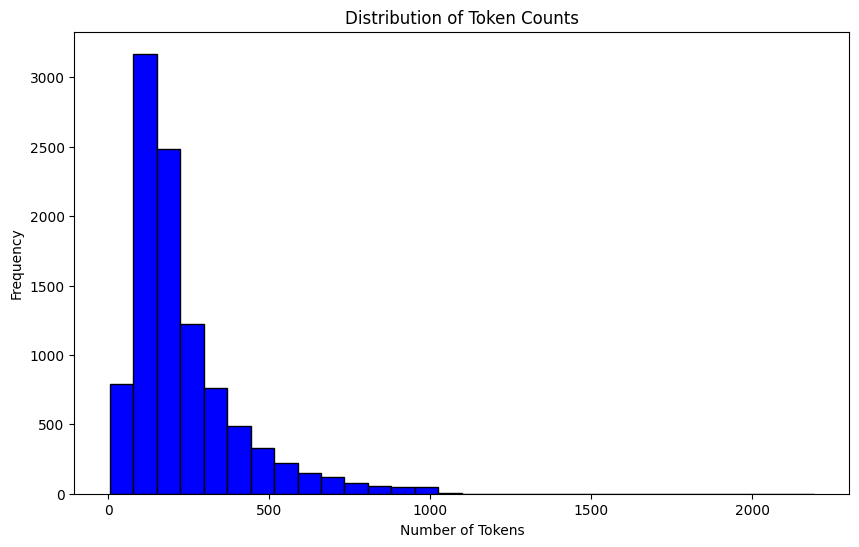

In [ ]:
# Plot histogram of token counts
plt.figure(figsize=(10, 6))
df['token_count'].plot(kind='hist', bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Token Counts')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

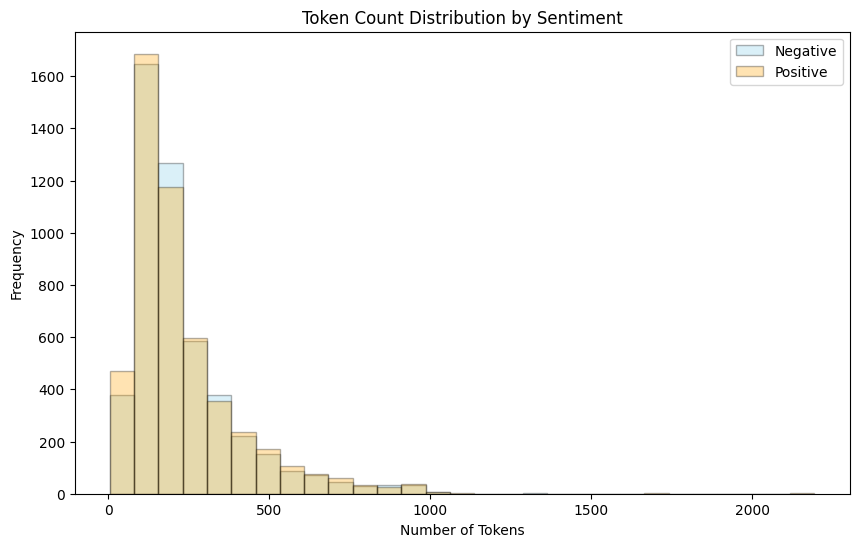

In [ ]:
# Set bins boundaries to be consistent
x_max = df['token_count'].max()
x_min = df['token_count'].min()
n_bin = 30
bins = np.linspace(x_min, x_max, n_bin)

plt.figure(figsize=(10, 6))

# Histogram for negative reviews (label 0)
plt.hist(df[df['label'] == 0]['token_count'], bins=bins, alpha=0.3, color='skyblue', edgecolor='black', label='Negative')

# Histogram for positive reviews (label 1)
plt.hist(df[df['label'] == 1]['token_count'], bins=bins, alpha=0.3, color='orange', edgecolor='black', label='Positive')

plt.title('Token Count Distribution by Sentiment')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Print descriptive statistics for negative and positive token counts
print("Negative token_count description")
print(df[df['label'] == 0]['token_count'].describe())
print("\nPositive token_count description")
print(df[df['label'] == 1]['token_count'].describe())

Negative token_count description
count    4940.000000
mean      229.670243
std       165.959385
min         4.000000
25%       127.000000
50%       175.000000
75%       280.000000
max      1334.000000
Name: token_count, dtype: float64

Positive token_count description
count    5038.000000
mean      231.357086
std       174.678946
min        14.000000
25%       123.000000
50%       173.000000
75%       284.000000
max      2192.000000
Name: token_count, dtype: float64


In [ ]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the cleaning function
def clean_text(text):
    # Remove special characters
    text = re.sub(r'[^A-Za-z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords and lemmatize
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(cleaned_words)

    # Remove extra spaces, tabs, and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the cleaning function and save the result to a new column
df['cleaned_text'] = df['text'].apply(clean_text)

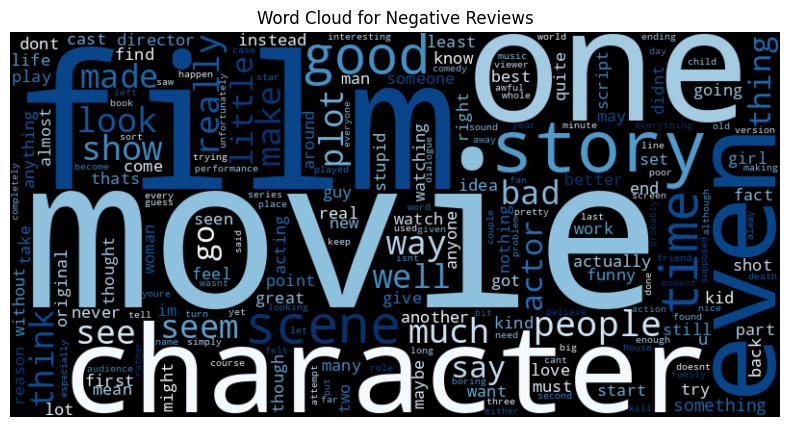

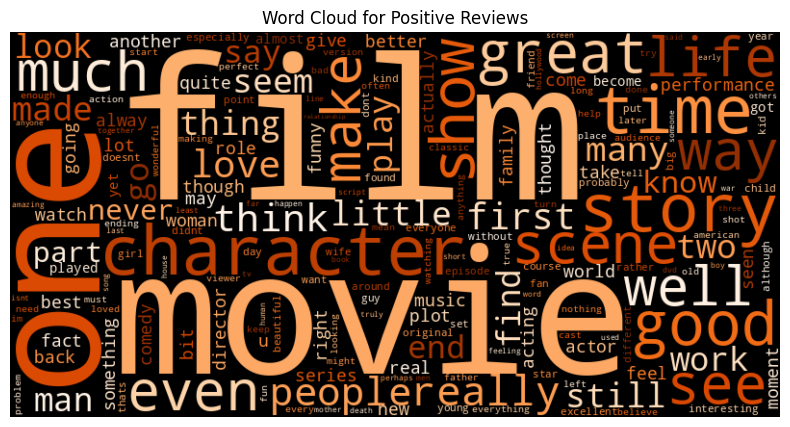

In [ ]:
# Generate text for negative and positive reviews
negative_text = ' '.join(df[df['label'] == 0]['cleaned_text'])
positive_text = ' '.join(df[df['label'] == 1]['cleaned_text'])

# Create Word Cloud for negative reviews
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

# Create Word Cloud for positive reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Oranges').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

## 2. Naive Bayes(Baseline Model)

In [ ]:
# Base model - Naive Bayes

# Split the train/test data
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

# Define the model pipeline
model_nb = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Train the model
model_nb.fit(X_train, y_train)

# Make predictions
y_pred = model_nb.predict(X_test)

In [ ]:
def evaluate_model(y_test, y_pred, model_name=''):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return cm

Accuracy for Naive Bayes: 0.844188376753507
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1002
           1       0.85      0.84      0.84       994

    accuracy                           0.84      1996
   macro avg       0.84      0.84      0.84      1996
weighted avg       0.84      0.84      0.84      1996



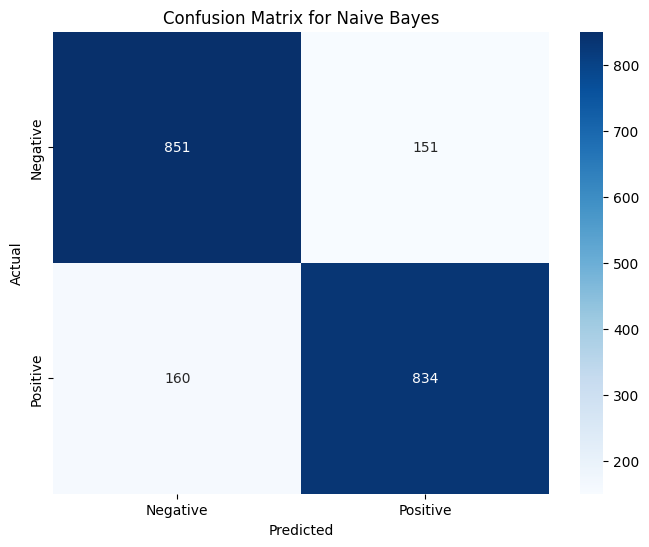

In [ ]:
# Evaluate the model
cm_nb = evaluate_model(y_test, y_pred, model_name='Naive Bayes')

## 3. Fine-Tuning BERT

### 3-0. Data Preprocessing for Fine-Tuning BERT

In [ ]:
# Split the train/test data
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize the text data
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=512)

# Apply the tokenization function to the training, validation, and test sets
train_encodings = tokenize_function(list(X_train))
val_encodings = tokenize_function(list(X_val))
test_encodings = tokenize_function(list(X_test))

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), list(y_train)))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), list(y_val)))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), list(y_test)))

# Batch the datasets
batch_size = 32

train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

### 3-1. Fine-tuning BERT - Dense Layer Only

#### 3-1-1. Learning Rate = 5e-5, Epoch = 4

In [ ]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the entire BERT model to non-trainable except the classification layer
model.bert.trainable = False
# Ensure that all sub-layers of the BERT model are also set to non-trainable
for layer in model.bert.submodules:
    layer.trainable = False
# The classifier layer will be trainable by default, but we explicitly set it here for clarity
model.classifier.trainable = True

# Model summary
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 1538 (6.01 KB)
Non-trainable params: 109482240 (417.64 MB)
_________________________________________________________________


In [ ]:
# Define the learning rate schedule
epochs = 4
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=5e-5,
    decay_steps=total_steps,
    end_learning_rate=0
)

# Instantiate the optimizer
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Train the model with validation dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/4
188/188 [==============================] - 397s 2s/step - loss: 0.6890 - accuracy: 0.5428 - val_loss: 0.6775 - val_accuracy: 0.6152
Epoch 2/4
188/188 [==============================] - 355s 2s/step - loss: 0.6802 - accuracy: 0.5747 - val_loss: 0.6702 - val_accuracy: 0.6293
Epoch 3/4
188/188 [==============================] - 355s 2s/step - loss: 0.6720 - accuracy: 0.6051 - val_loss: 0.6658 - val_accuracy: 0.6423
Epoch 4/4
188/188 [==============================] - 354s 2s/step - loss: 0.6701 - accuracy: 0.6099 - val_loss: 0.6643 - val_accuracy: 0.6528


In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks(epochs)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.xticks(epochs)

    plt.show()

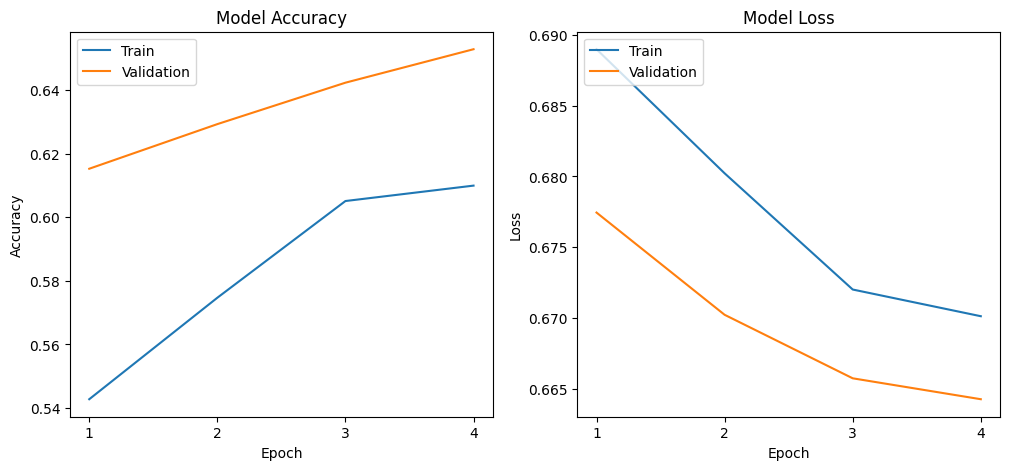

In [ ]:
plot_history(history)

63/63 [==============================] - 92s 1s/step
Accuracy for FineTunedBERT_Dense: 0.6297595190380761
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.44      0.55      1002
           1       0.59      0.82      0.69       994

    accuracy                           0.63      1996
   macro avg       0.65      0.63      0.62      1996
weighted avg       0.65      0.63      0.62      1996



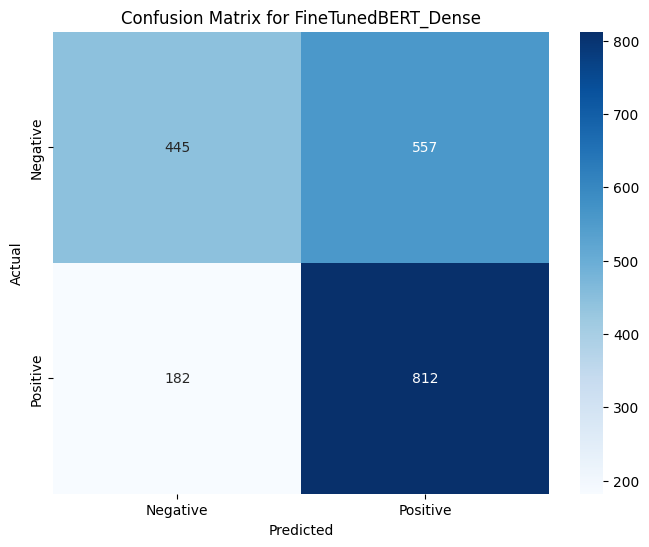

In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset)
pred_labels = tf.argmax(predictions.logits, axis=-1)
y_pred = pred_labels.numpy()

# Evaluate the model
cm = evaluate_model(y_test, y_pred, model_name='FineTunedBERT_Dense')

#### 3-1-2. Learning Rate = 1e-3, Epoch = 10

In [ ]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the entire BERT model to non-trainable except the classification layer
model.bert.trainable = False
# Ensure that all sub-layers of the BERT model are also set to non-trainable
for layer in model.bert.submodules:
    layer.trainable = False
# The classifier layer will be trainable by default, but we explicitly set it here for clarity
model.classifier.trainable = True

# Define the learning rate schedule
epochs = 10
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    end_learning_rate=0
)

# Instantiate the optimizer
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
188/188 [==============================] - 393s 2s/step - loss: 0.6452 - accuracy: 0.6261 - val_loss: 0.5748 - val_accuracy: 0.7249
Epoch 2/10
188/188 [==============================] - 355s 2s/step - loss: 0.5853 - accuracy: 0.6963 - val_loss: 0.5933 - val_accuracy: 0.6468
Epoch 3/10
188/188 [==============================] - 355s 2s/step - loss: 0.5540 - accuracy: 0.7366 - val_loss: 0.5288 - val_accuracy: 0.7325
Epoch 4/10
188/188 [==============================] - 355s 2s/step - loss: 0.5332 - accuracy: 0.7449 - val_loss: 0.4986 - val_accuracy: 0.7665
Epoch 5/10
188/188 [==============================] - 355s 2s/step - loss: 0.5188 - accuracy: 0.7533 - val_loss: 0.4774 - val_accuracy: 0.7921
Epoch 6/10
188/188 [==============================] - 355s 2s/step - loss: 0.5152 - accuracy: 0.7576 - val_loss: 0.4680 - val_accuracy: 0.7956
Epoch 7/10
188/188 [==============================] - 355s 2s/step - loss: 0.5108 - accuracy: 0.7599 - val_loss: 0.4662 - val_accuracy: 0.7961

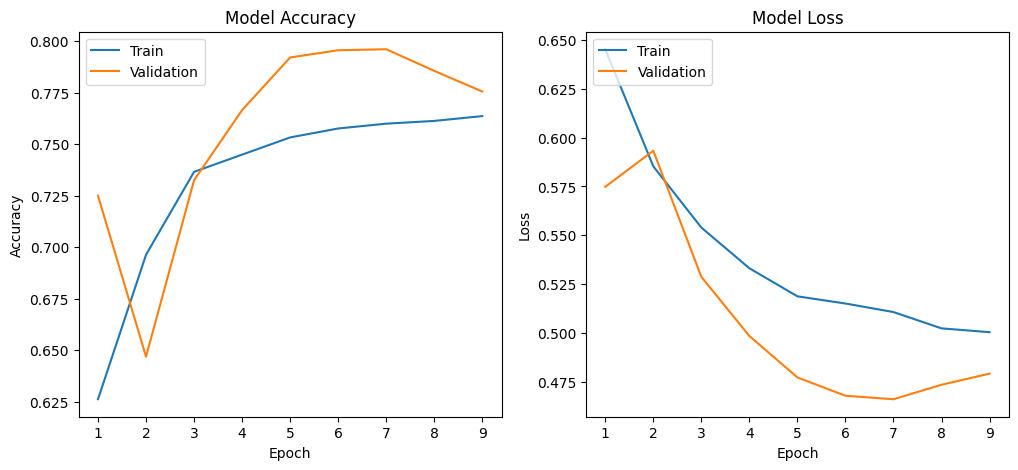

In [ ]:
plot_history(history)

63/63 [==============================] - 89s 1s/step
Accuracy for FineTunedBERT_Dense_ver2: 0.7875751503006012
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.78      1002
           1       0.76      0.84      0.80       994

    accuracy                           0.79      1996
   macro avg       0.79      0.79      0.79      1996
weighted avg       0.79      0.79      0.79      1996



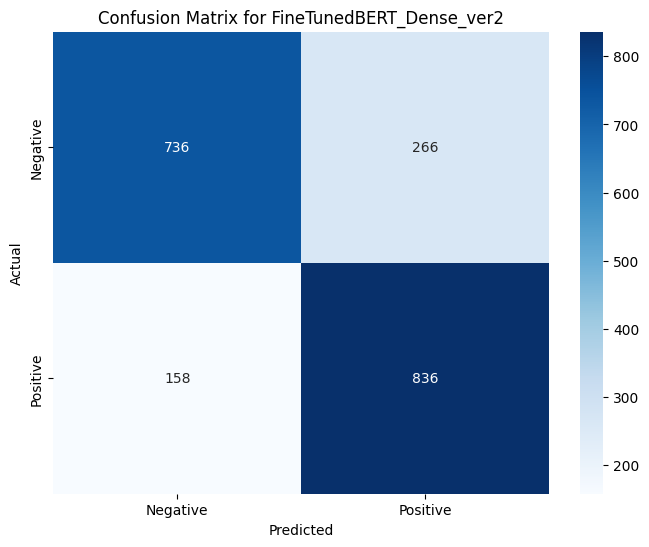

In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset)
pred_labels = tf.argmax(predictions.logits, axis=-1)
y_pred = pred_labels.numpy()

# Evaluate the model
cm = evaluate_model(y_test, y_pred, model_name='FineTunedBERT_Dense_ver2')

### 3-2. Fine-tuning BERT - Dense Layer and 1 Encoder Layer

#### 3-2-1. Learning Rate = 1e-3, Epoch = 10

In [ ]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the embeddings layer to non-trainable
model.bert.embeddings.trainable = False
# Set the BERT encoder layers from 1 to 11 to non-trainable
for layer in model.bert.encoder.layer[:11]:
    layer.trainable = False

# Model summary
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_227 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 7680002 (29.30 MB)
Non-trainable params: 101803776 (388.35 MB)
_________________________________________________________________


In [ ]:
# Function to count the number of parameters
def count_parameters(layer):
    return sum(p.numpy().size for p in layer.weights)

# Print BERT Embeddings Layer details
print("BERT Embeddings Layer:")
embeddings = model.bert.embeddings
print(f"Layer name: embeddings, Trainable: {embeddings.trainable}, Parameters: {count_parameters(embeddings)}")

# Print BERT Encoder Layers details
print("\nBERT Encoder Layers:")
for i, encoder_layer in enumerate(model.bert.encoder.layer):
    print(f"Encoder Layer {i} name: {encoder_layer.name}, Trainable: {encoder_layer.trainable}, Parameters: {count_parameters(encoder_layer)}")

# Print details of the Dense layer
print("\nDense Layer:")
dense_layer = model.classifier
print(f"Layer name: classifier, Trainable: {dense_layer.trainable}, Parameters: {count_parameters(dense_layer)}")

BERT Embeddings Layer:
Layer name: embeddings, Trainable: False, Parameters: 23837184

BERT Encoder Layers:
Encoder Layer 0 name: layer_._0, Trainable: False, Parameters: 7087872
Encoder Layer 1 name: layer_._1, Trainable: False, Parameters: 7087872
Encoder Layer 2 name: layer_._2, Trainable: False, Parameters: 7087872
Encoder Layer 3 name: layer_._3, Trainable: False, Parameters: 7087872
Encoder Layer 4 name: layer_._4, Trainable: False, Parameters: 7087872
Encoder Layer 5 name: layer_._5, Trainable: False, Parameters: 7087872
Encoder Layer 6 name: layer_._6, Trainable: False, Parameters: 7087872
Encoder Layer 7 name: layer_._7, Trainable: False, Parameters: 7087872
Encoder Layer 8 name: layer_._8, Trainable: False, Parameters: 7087872
Encoder Layer 9 name: layer_._9, Trainable: False, Parameters: 7087872
Encoder Layer 10 name: layer_._10, Trainable: False, Parameters: 7087872
Encoder Layer 11 name: layer_._11, Trainable: True, Parameters: 7087872

Dense Layer:
Layer name: classifier,

In [ ]:
# Define the learning rate schedule
epochs = 10
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    end_learning_rate=0
)

# Instantiate the optimizer
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
188/188 [==============================] - 417s 2s/step - loss: 0.3981 - accuracy: 0.8131 - val_loss: 0.2718 - val_accuracy: 0.8898
Epoch 2/10
188/188 [==============================] - 386s 2s/step - loss: 0.2810 - accuracy: 0.8841 - val_loss: 0.2676 - val_accuracy: 0.8918
Epoch 3/10
188/188 [==============================] - 386s 2s/step - loss: 0.2561 - accuracy: 0.9008 - val_loss: 0.2981 - val_accuracy: 0.8763
Epoch 4/10
188/188 [==============================] - 386s 2s/step - loss: 0.2498 - accuracy: 0.9001 - val_loss: 0.2668 - val_accuracy: 0.9008
Epoch 5/10
188/188 [==============================] - 386s 2s/step - loss: 0.2304 - accuracy: 0.9088 - val_loss: 0.2518 - val_accuracy: 0.9018
Epoch 6/10
188/188 [==============================] - 386s 2s/step - loss: 0.2089 - accuracy: 0.9155 - val_loss: 0.2433 - val_accuracy: 0.9003
Epoch 7/10
188/188 [==============================] - 386s 2s/step - loss: 0.2047 - accuracy: 0.9158 - val_loss: 0.2949 - val_accuracy: 0.9023

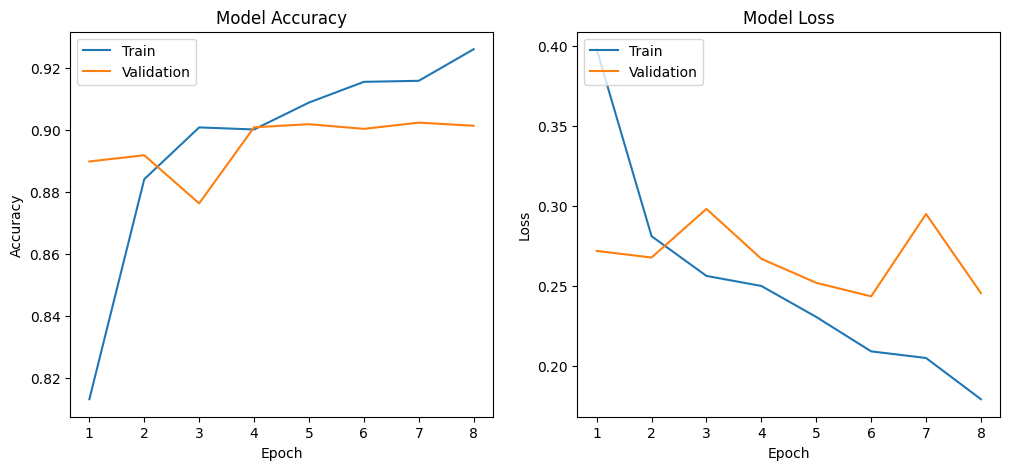

In [ ]:
plot_history(history)

63/63 [==============================] - 91s 1s/step
Accuracy for FineTunedBERT_Dense_Encoder1: 0.9008016032064128
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1002
           1       0.89      0.91      0.90       994

    accuracy                           0.90      1996
   macro avg       0.90      0.90      0.90      1996
weighted avg       0.90      0.90      0.90      1996



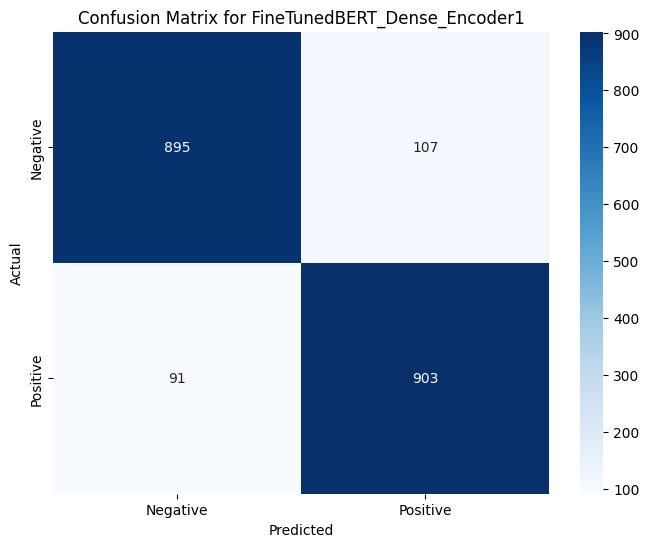

In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset)
pred_labels = tf.argmax(predictions.logits, axis=-1)
y_pred = pred_labels.numpy()

# Evaluate the model
cm = evaluate_model(y_test, y_pred, model_name='FineTunedBERT_Dense_Encoder1')

#### 3-2-2. Learning Rate = 1e-4, Epoch = 10

In [ ]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the embeddings layer to non-trainable
model.bert.embeddings.trainable = False
# Set the BERT encoder layers from 1 to 11 to non-trainable
for layer in model.bert.encoder.layer[:11]:
    layer.trainable = False

# Model summary
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_265 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 7680002 (29.30 MB)
Non-trainable params: 101803776 (388.35 MB)
_________________________________________________________________


In [ ]:
# Define the learning rate schedule
epochs = 10
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps,
    end_learning_rate=0
)

# Instantiate the optimizer
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
188/188 [==============================] - 430s 2s/step - loss: 0.3349 - accuracy: 0.8491 - val_loss: 0.2543 - val_accuracy: 0.8953
Epoch 2/10
188/188 [==============================] - 390s 2s/step - loss: 0.2324 - accuracy: 0.9078 - val_loss: 0.2441 - val_accuracy: 0.9018
Epoch 3/10
188/188 [==============================] - 390s 2s/step - loss: 0.1957 - accuracy: 0.9238 - val_loss: 0.2436 - val_accuracy: 0.9078
Epoch 4/10
188/188 [==============================] - 390s 2s/step - loss: 0.1675 - accuracy: 0.9328 - val_loss: 0.2577 - val_accuracy: 0.9083
Epoch 5/10
188/188 [==============================] - 390s 2s/step - loss: 0.1456 - accuracy: 0.9455 - val_loss: 0.2560 - val_accuracy: 0.9088


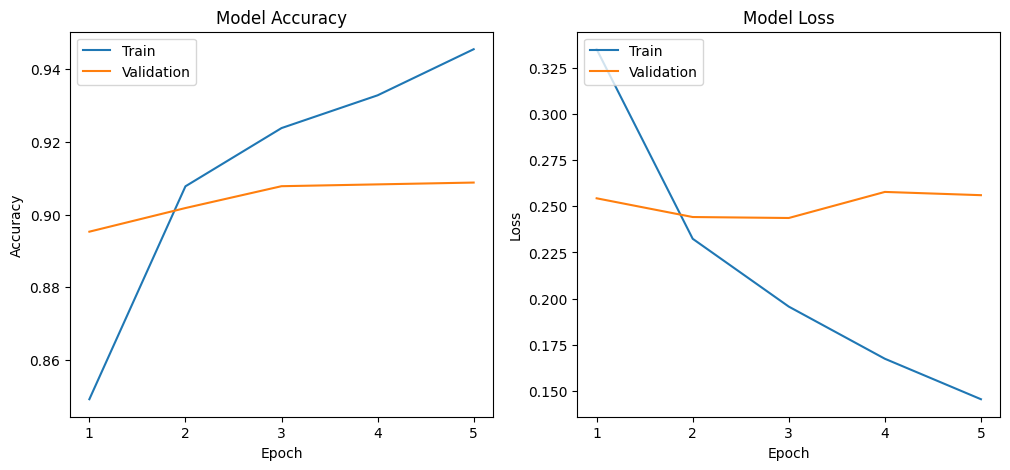

In [ ]:
plot_history(history)

63/63 [==============================] - 91s 1s/step
Accuracy for FineTunedBERT_Dense_Encoder1_ver2: 0.9153306613226453
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      1002
           1       0.89      0.95      0.92       994

    accuracy                           0.92      1996
   macro avg       0.92      0.92      0.92      1996
weighted avg       0.92      0.92      0.92      1996



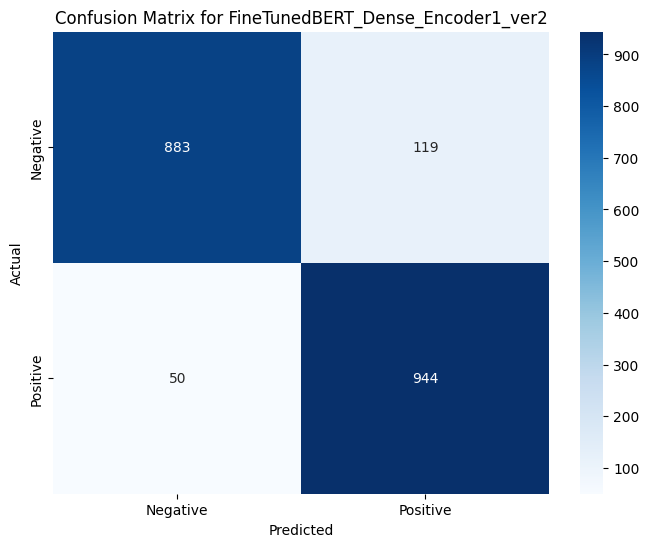

In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset)
pred_labels = tf.argmax(predictions.logits, axis=-1)
y_pred = pred_labels.numpy()

# Evaluate the model
cm = evaluate_model(y_test, y_pred, model_name='FineTunedBERT_Dense_Encoder1_ver2')

### 3-3. Fine-tuning BERT - Dense Layer and 3 Encoder Layers

#### 3-3-1. Learning Rate = 1e-4, Epoch = 10

In [ ]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the embeddings layer to non-trainable
model.bert.embeddings.trainable = False
# Set the BERT encoder layers from 0 to 8 to non-trainable (leaving last 3 layers trainable)
for layer in model.bert.encoder.layer[:9]:
    layer.trainable = False

# Model summary
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_341 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 21855746 (83.37 MB)
Non-trainable params: 87628032 (334.27 MB)
_________________________________________________________________


In [ ]:
# Print BERT Embeddings Layer details
print("BERT Embeddings Layer:")
embeddings = model.bert.embeddings
print(f"Layer name: embeddings, Trainable: {embeddings.trainable}, Parameters: {count_parameters(embeddings)}")

# Print BERT Encoder Layers details
print("\nBERT Encoder Layers:")
for i, encoder_layer in enumerate(model.bert.encoder.layer):
    print(f"Encoder Layer {i} name: {encoder_layer.name}, Trainable: {encoder_layer.trainable}, Parameters: {count_parameters(encoder_layer)}")

# Print details of the Dense layer
print("\nDense Layer:")
dense_layer = model.classifier
print(f"Layer name: classifier, Trainable: {dense_layer.trainable}, Parameters: {count_parameters(dense_layer)}")

BERT Embeddings Layer:
Layer name: embeddings, Trainable: False, Parameters: 23837184

BERT Encoder Layers:
Encoder Layer 0 name: layer_._0, Trainable: False, Parameters: 7087872
Encoder Layer 1 name: layer_._1, Trainable: False, Parameters: 7087872
Encoder Layer 2 name: layer_._2, Trainable: False, Parameters: 7087872
Encoder Layer 3 name: layer_._3, Trainable: False, Parameters: 7087872
Encoder Layer 4 name: layer_._4, Trainable: False, Parameters: 7087872
Encoder Layer 5 name: layer_._5, Trainable: False, Parameters: 7087872
Encoder Layer 6 name: layer_._6, Trainable: False, Parameters: 7087872
Encoder Layer 7 name: layer_._7, Trainable: False, Parameters: 7087872
Encoder Layer 8 name: layer_._8, Trainable: False, Parameters: 7087872
Encoder Layer 9 name: layer_._9, Trainable: True, Parameters: 7087872
Encoder Layer 10 name: layer_._10, Trainable: True, Parameters: 7087872
Encoder Layer 11 name: layer_._11, Trainable: True, Parameters: 7087872

Dense Layer:
Layer name: classifier, T

In [ ]:
# Define the learning rate schedule
epochs = 10
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-4,
    decay_steps=total_steps,
    end_learning_rate=0
)

# Instantiate the optimizer
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
188/188 [==============================] - 505s 2s/step - loss: 0.3151 - accuracy: 0.8555 - val_loss: 0.2360 - val_accuracy: 0.9088
Epoch 2/10
188/188 [==============================] - 459s 2s/step - loss: 0.1882 - accuracy: 0.9250 - val_loss: 0.2294 - val_accuracy: 0.9073
Epoch 3/10
188/188 [==============================] - 459s 2s/step - loss: 0.1398 - accuracy: 0.9477 - val_loss: 0.2778 - val_accuracy: 0.9008
Epoch 4/10
188/188 [==============================] - 459s 2s/step - loss: 0.0913 - accuracy: 0.9671 - val_loss: 0.2713 - val_accuracy: 0.9093


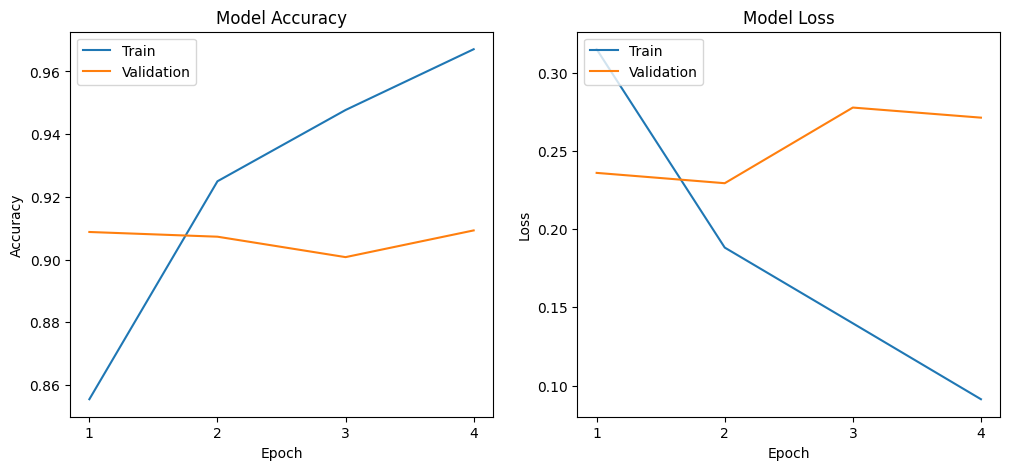

In [ ]:
plot_history(history)

63/63 [==============================] - 92s 1s/step
Accuracy for FineTunedBERT_Dense_Encoder3: 0.9173346693386774
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92      1002
           1       0.95      0.88      0.91       994

    accuracy                           0.92      1996
   macro avg       0.92      0.92      0.92      1996
weighted avg       0.92      0.92      0.92      1996



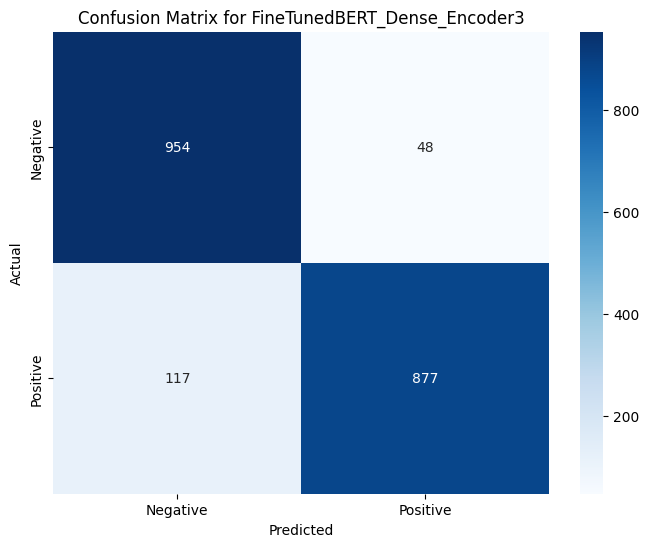

In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset)
pred_labels = tf.argmax(predictions.logits, axis=-1)
y_pred = pred_labels.numpy()

# Evaluate the model
cm = evaluate_model(y_test, y_pred, model_name='FineTunedBERT_Dense_Encoder3')

# Save the model in TensorFlow SavedModel format
model.save('model_ft_dense_encoder3', save_format='tf')
# Save the model weights
model.save_weights('weights_ft_dense_encoder3.h5')

# Save the history
with open('history_ft_dense_encoder3.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save the confusion matrix
with open('cm_ft_dense_encoder3.pkl', 'wb') as f:
    pickle.dump(cm, f)

#### 3-3-2. Learning Rate = 1e-5, Epoch = 10

In [ ]:
# Load the pre-trained BERT model with a classification head
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set the embeddings layer to non-trainable
model.bert.embeddings.trainable = False
# Set the BERT encoder layers from 0 to 8 to non-trainable (leaving last 3 layers trainable)
for layer in model.bert.encoder.layer[:9]:
    layer.trainable = False

# Model summary
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_379 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 21855746 (83.37 MB)
Non-trainable params: 87628032 (334.27 MB)
_________________________________________________________________


In [ ]:
# Define the learning rate schedule
epochs = 10
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * epochs

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

learning_rate_schedule = PolynomialDecay(
    initial_learning_rate=1e-5,
    decay_steps=total_steps,
    end_learning_rate=0
)

# Instantiate the optimizer
optimizer = Adam(learning_rate=learning_rate_schedule)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation dataset
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
188/188 [==============================] - 505s 3s/step - loss: 0.4884 - accuracy: 0.7670 - val_loss: 0.2855 - val_accuracy: 0.8873
Epoch 2/10
188/188 [==============================] - 459s 2s/step - loss: 0.2591 - accuracy: 0.8961 - val_loss: 0.2453 - val_accuracy: 0.9063
Epoch 3/10
188/188 [==============================] - 459s 2s/step - loss: 0.2227 - accuracy: 0.9096 - val_loss: 0.2357 - val_accuracy: 0.9033
Epoch 4/10
188/188 [==============================] - 460s 2s/step - loss: 0.2093 - accuracy: 0.9175 - val_loss: 0.2317 - val_accuracy: 0.9103
Epoch 5/10
188/188 [==============================] - 459s 2s/step - loss: 0.1838 - accuracy: 0.9312 - val_loss: 0.2283 - val_accuracy: 0.9098
Epoch 6/10
188/188 [==============================] - 459s 2s/step - loss: 0.1727 - accuracy: 0.9335 - val_loss: 0.2364 - val_accuracy: 0.9103
Epoch 7/10
188/188 [==============================] - 459s 2s/step - loss: 0.1634 - accuracy: 0.9390 - val_loss: 0.2276 - val_accuracy: 0.9098

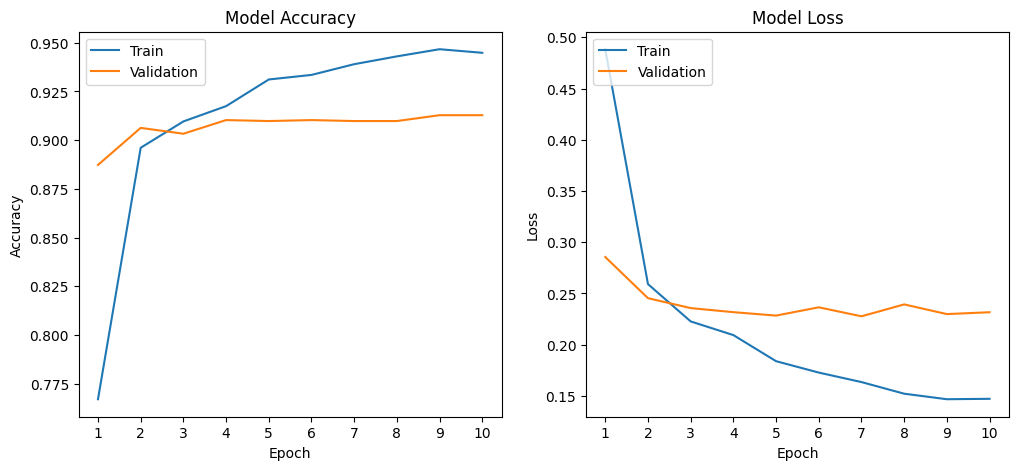

In [ ]:
plot_history(history)

63/63 [==============================] - 91s 1s/step
Accuracy for FineTunedBERT_Dense_Encoder3_ver2: 0.9188376753507014
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      1002
           1       0.91      0.93      0.92       994

    accuracy                           0.92      1996
   macro avg       0.92      0.92      0.92      1996
weighted avg       0.92      0.92      0.92      1996



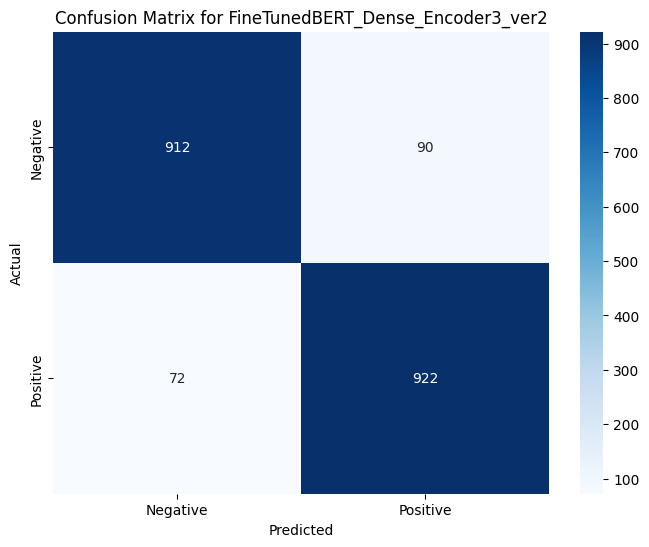

In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset)
pred_labels = tf.argmax(predictions.logits, axis=-1)
y_pred = pred_labels.numpy()

# Evaluate the model
cm = evaluate_model(y_test, y_pred, model_name='FineTunedBERT_Dense_Encoder3_ver2')

# Save the model in TensorFlow SavedModel format
model.save('model_ft_dense_encoder3_ver2', save_format='tf')
# Save the model weights
model.save_weights('weights_ft_dense_encoder3_ver2.h5')

# Save the history
with open('history_ft_dense_encoder3_ver2.pkl', 'wb') as f:
    pickle.dump(history.history, f)